In [24]:
import json
import math

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import torch

In [2]:
with open("../data/isoflops_curves.json", "r") as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data)
df

,parameters,compute_budget,final_loss
0,49999999,6.000000e+18,7.192785
1,78730505,6.000000e+18,6.750171
2,123969849,6.000000e+18,6.406640
3,195204177,6.000000e+18,6.154369
4,307370470,6.000000e+18,5.987783
...,...,...,...
67,12148905329,3.000000e+21,3.773188
68,20577985689,3.000000e+21,3.776239
69,34855279842,3.000000e+21,3.816546
70,59038360277,3.000000e+21,3.895885


In [9]:
param_opt = {}
token_opt = {}
for compute_budget in df["compute_budget"].unique():
    cdf = df.query("compute_budget == @compute_budget")
    opt_idx = cdf["final_loss"].argmin()
    param_opt[compute_budget] = cdf["parameters"].iloc[opt_idx]
    token_opt[compute_budget] = compute_budget / (6 * param_opt[compute_budget])

In [34]:
x = torch.tensor(df["compute_budget"].unique())
y_n = torch.tensor([param_opt[c.item()] for c in x])
y_d = torch.tensor([token_opt[c.item()] for c in x])
my_x_1 = 1e23
my_x_2 = 1e24

In [45]:
model_n = LinearRegression()
model_n.fit(x[:, None].log(), y_n.log())
w_n = model_n.coef_.item()
b_n = model_n.intercept_
my_y_n_1 = math.exp(w_n * math.log(my_x_1) + b_n)
my_y_n_2 = math.exp(w_n * math.log(my_x_2) + b_n)
print(w_n, b_n)
print(f"{my_y_n_1:.2e}, {my_y_n_2:.2e}")

0.46868272280540313 0.1513535996127544
7.01e+10, 2.06e+11


In [46]:
model_d = LinearRegression()
model_d.fit(x[:, None].log(), y_d.log())
w_d = model_d.coef_.item()
b_d = model_d.intercept_
my_y_d_1 = math.exp(w_d * math.log(my_x_1) + b_d)
my_y_d_2 = math.exp(w_d * math.log(my_x_2) + b_d)
print(w_d, b_d)
print(f"{my_y_d_1:.2e}, {my_y_d_2:.2e}")

0.5313173322562995 -1.943115364211259
2.38e+11, 8.09e+11


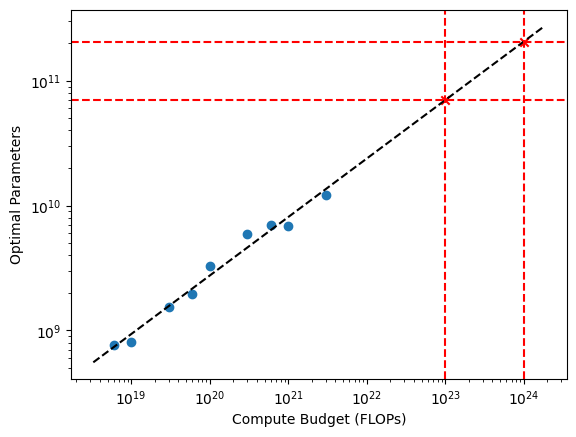

In [47]:
fig, ax = plt.subplots()
ax.scatter(x, y_n)
ax.set_xscale("log")
ax.set_yscale("log")
ax.scatter([my_x_1, my_x_2], [my_y_n_1, my_y_n_2], marker="x", color="red")
x_min, x_max = ax.get_xlim()
y_at_x_min = math.exp(w_n * math.log(x_min) + b_n)
y_at_x_max = math.exp(w_n * math.log(x_max) + b_n)
ax.plot([x_min, x_max], [y_at_x_min, y_at_x_max], ls="--", color="k")
ax.axvline(my_x_1, ls="--", color="red")
ax.axvline(my_x_2, ls="--", color="red")
ax.axhline(my_y_n_1, ls="--", color="red")
ax.axhline(my_y_n_2, ls="--", color="red")
ax.set_xlabel("Compute Budget (FLOPs)")
ax.set_ylabel("Optimal Parameters")
fig.show()

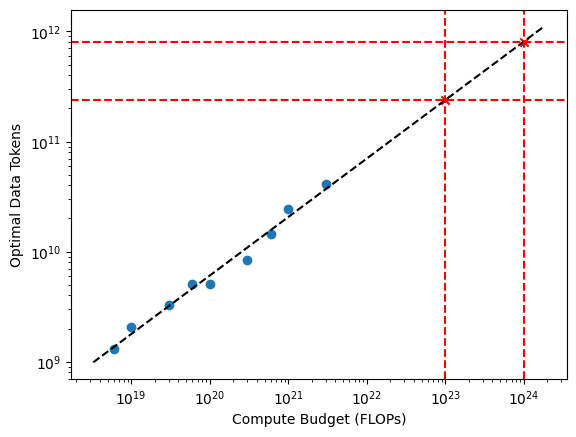

In [48]:
fig, ax = plt.subplots()
ax.scatter(x, y_d)
ax.set_xscale("log")
ax.set_yscale("log")
ax.scatter([my_x_1, my_x_2], [my_y_d_1, my_y_d_2], marker="x", color="red")
x_min, x_max = ax.get_xlim()
y_at_x_min = math.exp(w_d * math.log(x_min) + b_d)
y_at_x_max = math.exp(w_d * math.log(x_max) + b_d)
ax.plot([x_min, x_max], [y_at_x_min, y_at_x_max], ls="--", color="k")
ax.axvline(my_x_1, ls="--", color="red")
ax.axvline(my_x_2, ls="--", color="red")
ax.axhline(my_y_d_1, ls="--", color="red")
ax.axhline(my_y_d_2, ls="--", color="red")
ax.set_xlabel("Compute Budget (FLOPs)")
ax.set_ylabel("Optimal Data Tokens")
fig.show()

In [25]:
c = torch.tensor(df["compute_budget"])
c = c.unique().sort().values
log_c = c.log()
log_c_min = log_c[0]
log_c_max = log_c[-1]
log_c_scaled = (log_c - log_c_min) / (log_c_max - log_c_min)

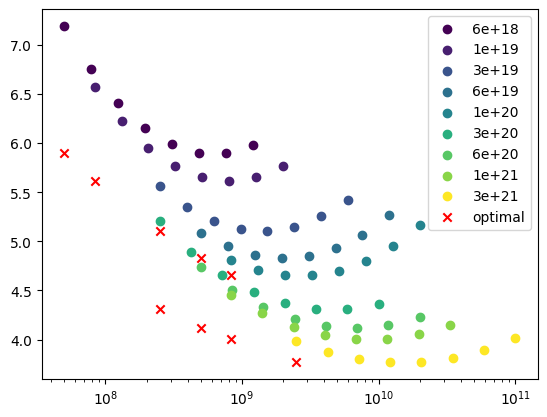

In [23]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("viridis")
for c_, log_c_scaled_ in zip(c, log_c_scaled):
    cdf = df.query(f"compute_budget == {c_.item()}")
    x = cdf["parameters"]
    y = cdf["final_loss"]
    color = cmap(log_c_scaled_)
    ax.scatter(x, y, color=color, label=c_.item())
x = n_opt_df["parameters"]
y = n_opt_df["final_loss"]
ax.scatter(x, y, color="red", marker="x", label="optimal")
ax.set_xscale("log")
ax.legend()
fig.show()